# Planning and prepping for next steps

I'm still not 100% sure where this will end up but I'm starting by visualizing the data in as many ways as I can. I was thinking through this process and made some notes on possible visualizations, and also just lists of dependent and independent variables I could look at. 

><div>
<img src="../assets/images/variables-notes-sm.jpg" width="500"/>
</div>

Some of these are easier to extract than others. Of course plain CGM data is probably the easiest but daily CGM histograms won't be too bad either. I don't even record pre-bolus time so that's not happening any time soon. Even if I started now I wouldn't have enough data to do anything meaningful for a while. And as far as I know there's not a really easy way to record pre-bolus time.

I also made some sketches of possible visualizations that I could put together:

><div>
<img src="../assets/images/plot-ideas-sm.jpg" width="500"/>
</div>


    


## Prep data

Most of what I need to make the plots in the figure above is not available yet. In the rest of this notebook I'm going to work on extracting what I will need.

In [1]:
# IMPORTS

# since this notebook lives in a sub-folder of the main project, I'll add the main folder to the python path
import sys
sys.path.append("../")

# Load my module
from tools.glooko import read_all

# Load extra stuff that I need
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema

# Plotting (matplotlib widge allows for interactivity in the live notebook)
import matplotlib.pyplot as plt
%matplotlib widget


In [2]:
# LOAD DATA

df_cgm, df_bolus, df_basal, df_insulin = read_all(r"../data")

# Extract carb correction and insulin correction from bolus dataframe; add as new columns (I think I want these 
# split out, but I'm not sure. If it works out I may add to my glooko module. 
df_bolus["carb_correction"] = np.divide(df_bolus["carbs_input"], df_bolus["carb_ratio"])
df_bolus["insulin_correction"] = df_bolus["insulin_delivered"] - df_bolus["carb_correction"]

## Get Unique Days

Since the plots I planned above all have date along the x axis, I'll need to split out the data by unique day. At this point I have only 2023 data, so technically year is not needed, but just in case I end up looking at data that spans two (or more???) years, I'll construct a column for "year-day". So it will look like "2023-018" for January 18th, 2023.

In [3]:
df_cgm["dayofyear"] = df_cgm["time"].dt.dayofyear
df_cgm["year"] = df_cgm["time"].dt.year
df_cgm["yearday"] = df_cgm["year"].astype(str) + '-' + df_cgm["dayofyear"].map('{:03.0f}'.format)

# Print a list of the unique day being analyzed
unique_days = np.unique(df_cgm["yearday"])
print(unique_days)

['2023-018' '2023-019' '2023-020' '2023-021' '2023-022' '2023-023'
 '2023-024' '2023-025' '2023-026' '2023-027' '2023-028' '2023-029'
 '2023-030' '2023-031' '2023-032' '2023-033' '2023-034' '2023-035'
 '2023-036' '2023-037' '2023-038' '2023-039' '2023-040' '2023-041'
 '2023-042' '2023-043' '2023-044' '2023-045' '2023-046']


## Histograms

In [4]:
# Set up histogram bins
bin_width = 10 # units - mg/dL
bin_min = 50
bin_max = 400
bin_edges = np.arange(bin_min, bin_max+1, bin_width)
bin_centers = bin_edges[:-1] + (bin_width/2)

# Loop through dates and compute BG histogram for each day
bg_histo_arr = [] # initialize a list to hold the histogram array
for day in unique_days:
    bg_sub = df_cgm[df_cgm["yearday"] == day]["bg"]
    count,_ = np.histogram(bg_sub, bins=bin_edges)
    bg_histo_arr.append(count)

# Convert to numpy array
bg_histo_arr = np.array(bg_histo_arr).transpose()


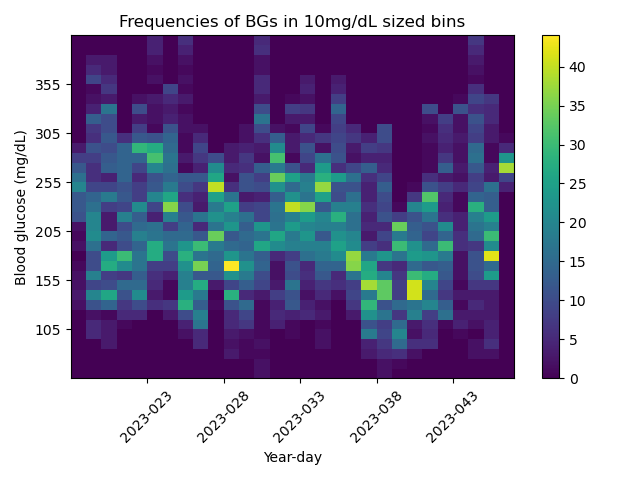

In [5]:
# Plot the 2D histogram
fig, ax = plt.subplots(1,1)
h = ax.pcolormesh(bg_histo_arr)

# x-axis
x = plt.xticks()[0]
x = x[(x>0) & (x<len(unique_days))]
ax.set_xticks(x)
ax.set_xticklabels(unique_days[[int(a) for a in x]], rotation=45)
ax.set_xlabel('Year-day')

# y-axis
y = plt.yticks()[0]
y = y[(y>0) & (y<len(bin_centers))]
ax.set_yticks(y)
bin_center_labels = np.array([int(a) for a in bin_centers])
ax.set_yticklabels(bin_center_labels[[int(a) for a in y]]);
ax.set_ylabel('Blood glucose (mg/dL)')

fig.colorbar(h, ax=ax)

ax.set_title('Frequencies of BGs in ' + str(bin_width) + 'mg/dL sized bins');

fig.tight_layout()

## Thoughts

- I am still interested in looking at the distributions of BGs across different days but I don't love this particular method of visualization.
- It's a little hard to see patterns the way I want to because it's hard to visually process subtle differences in color. I think it would be better to plot height explicitly - perhaps using [Seaborn's KDE functionality](https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot)
- I needed year-day to uniquely split out days, but it's not helpful for interpretation. Converting axis labels to something like month/day would probably be better.
- I didn't get to the CGMs per hour per day, and still want to look at that
- Even though I don't prefer it, I think I should add a function for generating this type of histogram and put it into a module for easier access.